In [45]:
HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this IPython notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Childhood Endangerment and Median Income
By Christy Liner

## Context

### - Texas Department of Family and Protective Services (DFPS) 

### - Child Abuse in 2017

The Texas Department of Family and Protective Services (DFPS) works with communities to promote safe and healthy families and protect children and vulnerable adults from abuse, neglect, and exploitation (source: dfps.state.tx.us). 

In 2017 alone, there were over 66,000 confirmed child victims in Texas. Understanding correlations between income levels and child endangerment can provide insight to key strategic decision makers on how to prevent child abuse. 

## Hypothesis

**Null hypothesis:** There is no significant difference in the victimization rate by income levels.

**Alternative hypothesis:** There is a significant difference in the victimization rate by income levels, which can be seen by median income levels per county. 

*A 95% confidence interval will be used. A p value below .05 on our statistical tests will indicate that the null hypothesis should be rejected.*

## Data Gathering
The data comes from the Texas Department of Family and Protective Services and US Census Bureau. *There are counties with no data.*

**Victim Data:** Abuse and Neglect Investigations Data from DFPS

**Population Data:** County Population from DFPS

**Median Income Data:** Median Income by County from US Census Bureau 

## Analysis Summary

**Process:**

 - DataFrame containing the number of confirmed victims per 100 children

 - View by county and the county’s corresponding median income level

 - Each county was assigned an income level

## Analysis Summary Continued

**Statistical tests to determine if null hypothesis should be rejected:**

 - Mood’s Median test 

 - Kruskal-Wallis 

 - Mann Whitney U

### The analysis included the following data: 

- County

- Median Income

- Median Income Level

- Child Population

- Total Population

- Child Victims

- Child Victims per 100 Children

## Conclusion

The null hypothesis should be rejected because a significant correlation was found between median income level and child victimization rates. Reasons for this conclusion will be provided below through statistical analysis. 

## Why does this matter? 

- 66,000 children per year

- Children don't have a voice

- We can make a difference 

# Imports and Data API

In [109]:
! pip install sodapy
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sodapy import Socrata
import requests
import config
%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- With over 66,000 confirmed child victims per year, that's 180 / day. This is too many to keep the status quo. 
- Children who don't have a voice, need us to fight for them. 
- With smart research and understanding how income impacts child abuse, we can take steps to reduce the number of children that are victimized every year. 

## Victim Data From DFPS

In [47]:
client = Socrata("data.texas.gov", config.api_key)
investigations = client.get(config.investigations_identifier, limit = 10000)
investigations_df1 = pd.DataFrame.from_records(investigations)

In [48]:
investigations_df1.head()

,confirmed_victims,county,fiscal_year,region,victims
0,Not Confirmed,Armstrong,2008,1-Lubbock,8
1,Confirmed Victim,Armstrong,2008,1-Lubbock,1
2,Not Confirmed,Bailey,2008,1-Lubbock,48
3,Confirmed Victim,Bailey,2008,1-Lubbock,49
4,Not Confirmed,Briscoe,2008,1-Lubbock,10


## Population Data From DFPS

In [49]:
populations = client.get(config.populations_identifier, limit = 10000)
populations_data_frame = pd.DataFrame.from_records(populations)

In [50]:
populations_data_frame.head()

,child_population,county,of_children_in_total_population,region,total_population,year
0,11237,Anderson,19.9100,4-Tyler,56445,2008
1,3821,Andrews,27.4700,9-Midland,13908,2008
2,22131,Angelina,26.6400,5-Beaumont,83083,2008
3,5020,Aransas,19.8200,11-Edinburg,25327,2008
4,2216,Archer,23.9600,2-Abilene,9248,2008


## Income Data From US Census Bureau

In [51]:
income_df = pd.read_excel('https://www2.census.gov/programs-surveys/saipe/datasets/2017/2017-state-and-county/est17all.xls', header=3)
texas_income_df1 = income_df.loc[(income_df['Postal Code']=='TX'), ['Name', 'Median Household Income']]

In [52]:
texas_income_df1.head()

,Name,Median Household Income
2567,Texas,59195
2568,Anderson County,42412
2569,Andrews County,63451
2570,Angelina County,45318
2571,Aransas County,46970


# Cleaning the Data

- Updating numbers to be integers rather than objects

In [100]:
investigations_df = investigations_df1.astype({'fiscal_year': 'int64', 'victims': 'int64'}, copy = False)
updated_populations_df = populations_data_frame.astype({'child_population' : 'float64', 
                                                        'total_population': 'int64', 
                                                        'year': 'int64'}, 
                                                       copy = False, )
texas_income_df = texas_income_df1.astype({'Median Household Income': 'int64'}, copy = False)

- Separating Out Confirmed Victims

In [101]:
confirmed_df = investigations_df.loc[investigations_df['confirmed_victims'] == 'Confirmed Victim']

- Removing unnecessary data (totals, other years)

In [102]:
populations_2017 = updated_populations_df.loc[(updated_populations_df['year']==2017) 
                                              & (updated_populations_df['county'] != 'All Counties')]
confirmed_2017 = confirmed_df.loc[(confirmed_df['fiscal_year']==2017) 
                                  & (confirmed_df['county'] != 'Out of State')]

- Misspelling

- Missing data

In [103]:
populations_2017.iloc[160,1] = 'McLennan'
populations_2017.iloc[138,1] = 'La Salle'

# Combining Data into Single Data Frame

In [57]:
#Number of unique counties
populations_2017['county'].nunique()

254

In [58]:
combined_df = pd.merge(confirmed_2017, populations_2017, on = 'county', how = 'outer')

In [59]:
values = {'confirmed_victims': 'Confirmed Victim', 'fiscal_year': 2017, 'victims': 0}
combined_df = combined_df.fillna(value=values)

## Snapshot of the Data 

In [60]:
combined_df.head(10)

,confirmed_victims,county,fiscal_year,region_x,victims,child_population,of_children_in_total_population,region_y,total_population,year
0,Confirmed Victim,Bailey,2017.0,1-Lubbock,12.0,2463.0,30.6800,1-Lubbock,8029,2017
1,Confirmed Victim,Briscoe,2017.0,1-Lubbock,2.0,351.0,20.9100,1-Lubbock,1679,2017
2,Confirmed Victim,Carson,2017.0,1-Lubbock,23.0,1492.0,23.2500,1-Lubbock,6418,2017
3,Confirmed Victim,Castro,2017.0,1-Lubbock,12.0,2481.0,28.6400,1-Lubbock,8662,2017
4,Confirmed Victim,Childress,2017.0,1-Lubbock,25.0,1522.0,20.7300,1-Lubbock,7341,2017
5,Confirmed Victim,Cochran,2017.0,1-Lubbock,10.0,886.0,26.2600,1-Lubbock,3374,2017
6,Confirmed Victim,Collingsworth,2017.0,1-Lubbock,6.0,839.0,26.3600,1-Lubbock,3183,2017
7,Confirmed Victim,Crosby,2017.0,1-Lubbock,22.0,1845.0,26.900,1-Lubbock,6860,2017
8,Confirmed Victim,Dallam,2017.0,1-Lubbock,16.0,2262.0,29.5300,1-Lubbock,7660,2017
9,Confirmed Victim,Deaf Smith,2017.0,1-Lubbock,50.0,6761.0,31.2700,1-Lubbock,21621,2017


In [61]:
#Take out the word 'county' from the name so it can be joined with the other dataframes. 
texas_income_df['Name'] = texas_income_df['Name'].str.replace(' County', '', regex=True)

In [62]:
#Rename "Name" with 'county'
texas_income_df.rename(columns = {'Name': 'county'}, inplace = True)

## Merging with Income Data 

Here I combined all Income Data to show Median Income for 2017

In [63]:
combined_df_1 = pd.merge(combined_df, texas_income_df, on = 'county', how = 'inner')

In [64]:
combined_df_1.head()

,confirmed_victims,county,fiscal_year,region_x,victims,child_population,of_children_in_total_population,region_y,total_population,year,Median Household Income
0,Confirmed Victim,Bailey,2017.0,1-Lubbock,12.0,2463.0,30.6800,1-Lubbock,8029,2017,42045
1,Confirmed Victim,Briscoe,2017.0,1-Lubbock,2.0,351.0,20.9100,1-Lubbock,1679,2017,42678
2,Confirmed Victim,Carson,2017.0,1-Lubbock,23.0,1492.0,23.2500,1-Lubbock,6418,2017,60668
3,Confirmed Victim,Castro,2017.0,1-Lubbock,12.0,2481.0,28.6400,1-Lubbock,8662,2017,41746
4,Confirmed Victim,Childress,2017.0,1-Lubbock,25.0,1522.0,20.7300,1-Lubbock,7341,2017,40925


In [65]:
#Keeping Only Columns Needed
clean_2017_df = combined_df_1.iloc[:, [0, 1, 4, 5, 7, 8, 10]]

clean_2017_df.head()

,confirmed_victims,county,victims,child_population,region_y,total_population,Median Household Income
0,Confirmed Victim,Bailey,12.0,2463.0,1-Lubbock,8029,42045
1,Confirmed Victim,Briscoe,2.0,351.0,1-Lubbock,1679,42678
2,Confirmed Victim,Carson,23.0,1492.0,1-Lubbock,6418,60668
3,Confirmed Victim,Castro,12.0,2481.0,1-Lubbock,8662,41746
4,Confirmed Victim,Childress,25.0,1522.0,1-Lubbock,7341,40925


In [66]:
#Adding Victims Per 100 Children Column
clean_2017_df['victims_per_100_children']= clean_2017_df['victims'] / clean_2017_df['child_population'] * 100

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
#Understanding Median Income for Texas Overall in 2017
median_income = pd.read_excel('https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xls', header = 4)
texas_median_income = median_income.loc[median_income['State']=='Texas']

In [68]:
#Defining Groups for Median Household Income
conditions = [(clean_2017_df['Median Household Income'] > 70000),
              (clean_2017_df['Median Household Income'] > 50000),
              (clean_2017_df['Median Household Income'] <= 50000)]
choices = ['high', 'median', 'low']
                                                    
clean_2017_df['Median Household Income Level'] = np.select(conditions, choices, default = 'null')                                                    

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## Defining Groups for Median Household Income

-  High: Median County Income is Greater than \\$70,000 
-  Middle: Median County Income is \\$50,000 - \\$70,000
-  Low: Median County Income is Less than \\$50,000

## Final Data Set for Analysis

In [69]:
#Glance at the final data set
clean_2017_df.head(5)

,confirmed_victims,county,victims,child_population,region_y,total_population,Median Household Income,victims_per_100_children,Median Household Income Level
0,Confirmed Victim,Bailey,12.0,2463.0,1-Lubbock,8029,42045,0.487211,low
1,Confirmed Victim,Briscoe,2.0,351.0,1-Lubbock,1679,42678,0.569801,low
2,Confirmed Victim,Carson,23.0,1492.0,1-Lubbock,6418,60668,1.541555,median
3,Confirmed Victim,Castro,12.0,2481.0,1-Lubbock,8662,41746,0.483676,low
4,Confirmed Victim,Childress,25.0,1522.0,1-Lubbock,7341,40925,1.642576,low


In [70]:
#Quick glance at the data again, grouped by income level
pd.pivot_table(clean_2017_df, index = ['Median Household Income Level', 'county'], values = ['child_population', 'victims', 'victims_per_100_children'])

child_population  victims  \
Median Household Income Level county                                    
high                          Brazoria              101759.0    655.0   
                              Chambers               11143.0     66.0   
                              Collin                264138.0   1149.0   
                              Comal                  28784.0    455.0   
                              Denton                217520.0    932.0   
                              Ellis                  47430.0    372.0   
                              Fort Bend             210720.0    737.0   
                              Glasscock                300.0      3.0   
                              Kendall                 8590.0     39.0   
                              Midland                40745.0    203.0   
                              Montgomery            147799.0    807.0   
                              Parker                 33966.0    443.0   
                              Rockwall               26873.0     98.0   
                              Travis                291482.0   2172.0   
                              Williamson            146988.0    596.0   
                              Wilson                 12020.0     87.0   
low                           Anderson               11584.0    216.0   
                              Angelina               23881.0    286.0   
                              Aransas                 4572.0     85.0   
                              Atascosa               13676.0    308.0   
                              Bailey                  2463.0     12.0   
                              Baylor                   740.0     12.0   
                              Bee                     6863.0     94.0   
                              Bosque                  4120.0     49.0   
                              Bowie                  21801.0    239.0   
                              Brazos                 53512.0    302.0   
                              Brewster                2163.0     17.0   
                              Briscoe                  351.0      2.0   
                              Brooks                  2059.0     37.0   
                              Brown                   9202.0    204.0   
...                                                      ...      ...   
median                        Loving                     5.0      0.0   
                              Martin                  1466.0     20.0   
                              McMullen                 136.0      1.0   
                              Medina                 12540.0    108.0   
                              Moore                   7666.0     65.0   
                              Nueces                 89130.0   1244.0   
                              Ochiltree               3734.0     29.0   
                              Oldham                   478.0      0.0   
                              Orange                 21014.0    244.0   
                              Randall                33242.0    316.0   
                              Reagan                  1001.0      7.0   
                              Roberts                  239.0      3.0   
                              San Patricio           18349.0    216.0   
                              Scurry                  4567.0     57.0   
                              Shackelford              812.0     14.0   
                              Smith                  57561.0    517.0   
                              Somervell               2211.0     39.0   
                              Sterling                 279.0      1.0   
                              Sutton                  1113.0     20.0   
                              Tarrant               538318.0   5630.0   
                              Taylor                 34122.0    800.0   
                              Upton                    974.0      6.0   
                             

## Understanding the Data Visually

Separating into three distinct data frames based on income level

In [105]:
high_income = clean_2017_df.loc[clean_2017_df['Median Household Income Level']== 'high']
median_income = clean_2017_df.loc[clean_2017_df['Median Household Income Level']=='median']
low_income = clean_2017_df.loc[clean_2017_df['Median Household Income Level']=='low']

Compare where the density is on each income level

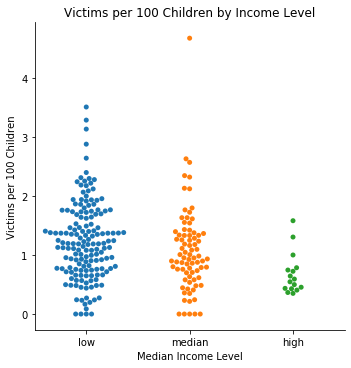

In [110]:
catplot = sns.catplot(x = 'Median Household Income Level', y = 'victims_per_100_children', data = clean_2017_df, kind = 'swarm')
plt.title('Victims per 100 Children by Income Level')
catplot.set_axis_labels("Median Income Level", "Victims per 100 Children");

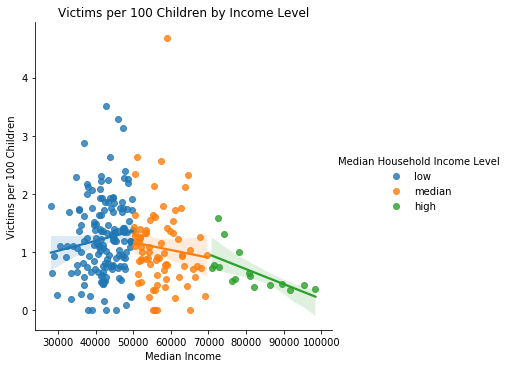

In [111]:
graph = sns.lmplot(x='Median Household Income', y='victims_per_100_children', hue='Median Household Income Level',
               truncate=True, height=5, data=clean_2017_df)

plt.title('Victims per 100 Children by Income Level')
graph.set_axis_labels("Median Income", "Victims per 100 Children");

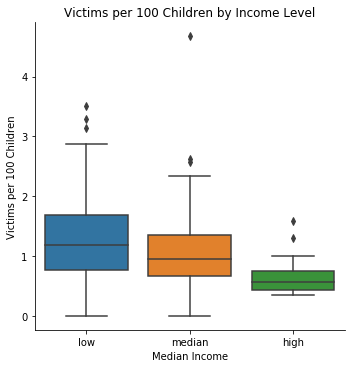

In [112]:
boxplot = sns.catplot(x = 'Median Household Income Level', y = 'victims_per_100_children', data = clean_2017_df, kind = 'box')
plt.title('Victims per 100 Children by Income Level')
boxplot.set_axis_labels("Median Income", "Victims per 100 Children");

# Testing for Normality

In [93]:
print('High Income: \n')
print(stats.describe(high_income['victims_per_100_children']))

print('\nMiddle Income:\n')
print(stats.describe(median_income['victims_per_100_children']))

print('\nLow Income:\n')
print(stats.describe(low_income['victims_per_100_children']))

High Income: 

DescribeResult(nobs=16, minmax=(0.3497532270311314, 1.5807392996108949), mean=0.6784905768307274, variance=0.12257643103455808, skewness=1.407525086989503, kurtosis=1.094669120680412)

Middle Income:

DescribeResult(nobs=79, minmax=(0.0, 4.672897196261682), mean=1.0733820473120834, variance=0.5145473900162764, skewness=1.7879122380882924, kurtosis=6.672581607965144)

Low Income:

DescribeResult(nobs=159, minmax=(0.0, 3.5069623517276947), mean=1.232750326237097, variance=0.43020210533007125, skewness=0.6124192423332706, kurtosis=0.7029282949772253)


In [76]:
print(stats.shapiro(high_income['victims_per_100_children']))
print(stats.shapiro(median_income['victims_per_100_children']))
print(stats.shapiro(low_income['victims_per_100_children']))

(0.8255553245544434, 0.006074231583625078)
(0.8789090514183044, 1.9737217371584848e-06)
(0.973885715007782, 0.0041335392743349075)


## Method for Analysis
Due to high kurtosis in the Median Income Level, these are not considered normal distributions. I will use Mood's Median test, Kruskal-Wallis, and Mann Whitney U to accept or reject the null hypothesis. 

## Cut off to Reject the Null Hypothesis 
I am using a 95% confidence interval. A p-value below .05 indicates that the populations are significantly different and that the null hypothesis can be rejected. If a p value is above .05, the null hypothesis will be accepted. 

## Mood's Median Test

Mood's Median Test is used when we have visible outliers for non-normal, independent groups. Since we have some visible outliers, Mood's will be used as part of our analysis. Since Mood's is less robust than other statistical analysis methods, we will also review Kruskal-Wallis and Mann Whitney U. A P value below .05 indicates that we can reject the null hypothesis.

The first row of the table shows us the values above the grand median, the second row shows us the values below the grand median. So high income, median income, low income, have 2, 34, and 91 counties above the grand median, respectively. The high income, median income, and low income also have 14, 45, and 68 counties below the grand median.

However, we can't compare this horizontally because the groups have different sample sizes. We need to compare each group and how much is above, and how much is below.

In [77]:
stat, p_value, median, table = stats.median_test(high_income['victims_per_100_children'], median_income['victims_per_100_children'], low_income['victims_per_100_children'])
print('Test Statistic: {}'.format(stat))
print('P-Value: {}'.format(p_value))
print('Median: {}'.format(median))
print('Table: {}'.format(table))

Test Statistic: 13.858689594777484
P-Value: 0.0009786418670872559
Median: 1.0899548674845825
Table: [[ 2 34 91]
 [14 45 68]]


The p value of .00098 indicates that we can reject the null hypothesis. The low p value suggests that there is a significant difference between the three groups. However, it does not indicate which group(s) the significant difference comes from. We will continue on with statistical analysis to uncover the differences in the three groups.

## Kruskal-Wallis

A p value below .05 indicates that we can reject the null hypothesis. 

In [78]:
stats.kruskal(high_income['victims_per_100_children'], median_income['victims_per_100_children'], low_income['victims_per_100_children'])

KruskalResult(statistic=16.65869810603693, pvalue=0.0002413290862004451)

The low p value suggests that there is a significant difference between the three groups. However, it does not indicate which group(s) the significant difference comes from. 

## Mann Whitney U Test

A p value below .05 indicates that we can reject the null hypothesis.

In [99]:
print('High and Middle: {}'.format(stats.mannwhitneyu(high_income['victims_per_100_children'], median_income['victims_per_100_children'])))
print('\nHigh and Low: {}'.format(stats.mannwhitneyu(high_income['victims_per_100_children'], low_income['victims_per_100_children'])))
print('\nMiddle and Low: {}'.format(stats.mannwhitneyu(median_income['victims_per_100_children'], low_income['victims_per_100_children'])))

High and Middle: MannwhitneyuResult(statistic=368.0, pvalue=0.004389399948901571)

High and Low: MannwhitneyuResult(statistic=549.0, pvalue=9.187020757054337e-05)

Middle and Low: MannwhitneyuResult(statistic=5197.0, pvalue=0.015182064758560054)


**High and Middle:** MannwhitneyuResult(statistic=368.0, pvalue=0.004)

**High and Low:** MannwhitneyuResult(statistic=549.0, pvalue=.0001)

**Middle and Low:** MannwhitneyuResult(statistic=5197.0, pvalue=0.015)

The very low p values further indicate a significant difference between each group. The largest variance in groups is from the high and low income levels with a p value of .0001. This indicates that the child removal rates between the two groups is significantly different. We can also see that there is a difference between high and middle, and middle and low (although the difference is not as large as between high and low). 

## Conclusion

There is a significant correlation between income level and child endangerment. While this does not confirm that income level causes child endangerment, it does indicate that there is a significant correlation between the two.  

## What Is Next?

**Further Analysis:**

The relationship between drug use, median income levels, and child victimization rates



This research hopes to be used in conjunction with high level strategy in reducing child endangerment through various programs (such as drug rehab, drug use prevention, workforce preparation assistance, job creation, etc.).

## Thank you for listening! 

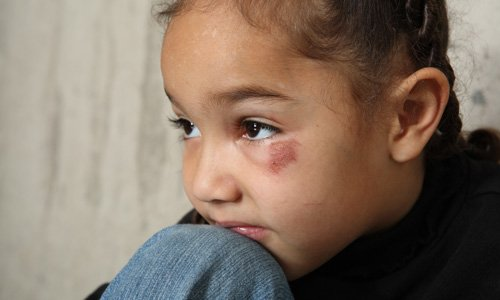

Children like her thank you for taking the time to consider different ways to reduce child abuse. 